In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image_size = (128, 128)
batch_size = 32

In [3]:
res_net_101 = tf.keras.applications.ResNet101(include_top=False,
                                              weights='imagenet',
                                             input_shape=image_size+(3,))

In [29]:
res_net_101.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                      

In [4]:
len(res_net_101.layers)

345

In [5]:
layers_finetune = 10

In [18]:
res_net_101.trainable = True

for layer in res_net_101.layers[:len(res_net_101.layers) - layers_finetune]:
    layer.trainable = False

In [19]:
res_net_101.summary(show_trainable=True)

Model: "resnet101"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            N          
                                                                                                             
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             N          
                                                                                                             
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           N          
                                                                                                             
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          N  

In [7]:
train_data = tf.keras.utils.image_dataset_from_directory('Training/', 
                                                        image_size=image_size,
                                                        validation_split=0.2,
                                                        subset='training',
                                                        shuffle=True,
                                                        seed=10)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [8]:
class_names = train_data.class_names

In [9]:
num_classes = len(class_names)

In [10]:
val_data = tf.keras.utils.image_dataset_from_directory('Training/',
                                                      image_size=image_size,
                                                      validation_split=0.2,
                                                      subset='validation',
                                                      shuffle=True,
                                                      seed=10)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [11]:
test_data = tf.keras.utils.image_dataset_from_directory('Testing/',
                                                       image_size=image_size,
                                                       batch_size=32,
                                                       shuffle=False,
                                                       seed=10)

Found 1311 files belonging to 4 classes.


In [12]:
rescale_fn = tf.keras.layers.Rescaling(scale=1./255)

train_data = train_data.map(lambda x, y: (rescale_fn(x), y))
val_data = val_data.map(lambda x, y: (rescale_fn(x), y))
test_data = test_data.map(lambda x, y: (rescale_fn(x), y))

In [20]:
cnn = tf.keras.Sequential([
    res_net_101,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [21]:
cnn.compile(optimizer = 'adam',   
            loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
            metrics = ['accuracy'])

In [22]:
history = cnn.fit(train_data,
       validation_data=val_data,
       epochs=15)

Epoch 1/15
143/143 [==============================] - 162s 1s/step - loss: 0.9378 - accuracy: 0.6495 - val_loss: 0.9647 - val_accuracy: 0.6436
Epoch 2/15
143/143 [==============================] - 151s 1s/step - loss: 0.6301 - accuracy: 0.7521 - val_loss: 0.5043 - val_accuracy: 0.8056
Epoch 3/15
143/143 [==============================] - 147s 1s/step - loss: 0.5396 - accuracy: 0.7928 - val_loss: 0.5565 - val_accuracy: 0.7793
Epoch 4/15
143/143 [==============================] - 150s 1s/step - loss: 0.4915 - accuracy: 0.8088 - val_loss: 0.4457 - val_accuracy: 0.8222
Epoch 5/15
143/143 [==============================] - 146s 1s/step - loss: 0.4553 - accuracy: 0.8214 - val_loss: 0.9004 - val_accuracy: 0.6278
Epoch 6/15
143/143 [==============================] - 148s 1s/step - loss: 0.4567 - accuracy: 0.8241 - val_loss: 0.4316 - val_accuracy: 0.8363
Epoch 7/15
143/143 [==============================] - 165s 1s/step - loss: 0.4083 - accuracy: 0.8453 - val_loss: 0.4630 - val_accuracy: 0.8109

In [23]:
cnn.save('saved_models/resnet101_freeze.keras')

In [24]:
y_pred = cnn.predict(test_data)

41/41 [==============================] - 29s 665ms/step


In [25]:
y_pred = tf.argmax(y_pred, axis=1).numpy()

In [26]:
y_true = []
for images, labels in test_data:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay

In [28]:
accuracy_score(y_true, y_pred)

0.7581998474446987

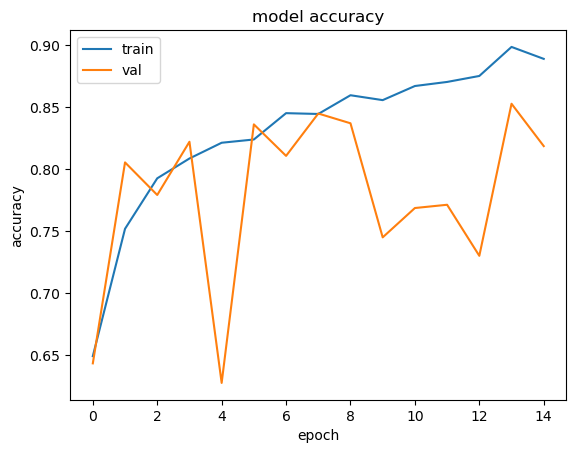

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

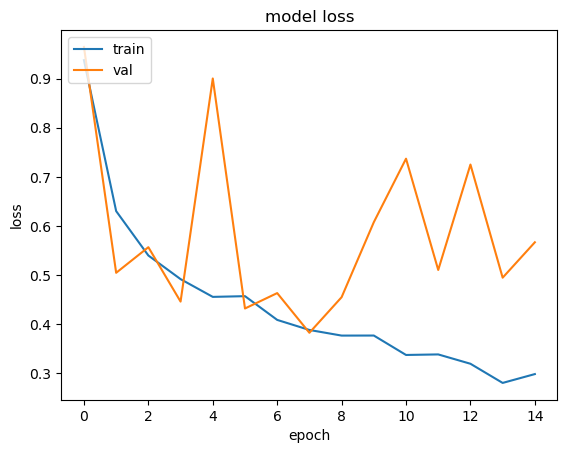

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
accuracy_score(y_true, y_pred)

0.7581998474446987

In [32]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[106, 173,   3,  18],
       [  6, 272,   4,  24],
       [  3,  65, 328,   9],
       [  0,  12,   0, 288]], dtype=int64)

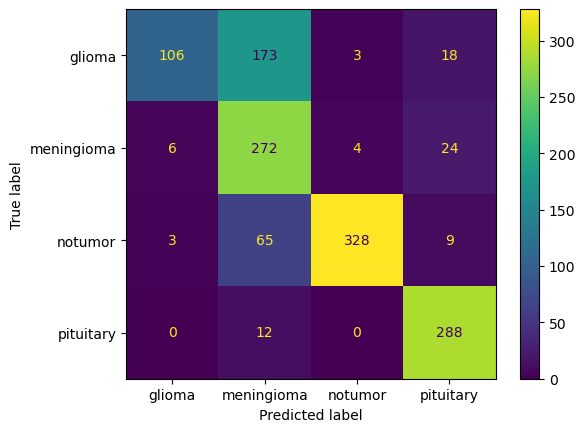

In [33]:
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cmd.plot()
plt.show()

In [34]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.92      0.35      0.51       300
  meningioma       0.52      0.89      0.66       306
     notumor       0.98      0.81      0.89       405
   pituitary       0.85      0.96      0.90       300

    accuracy                           0.76      1311
   macro avg       0.82      0.75      0.74      1311
weighted avg       0.83      0.76      0.75      1311

